In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Base directory for the dataset
base_path = '.'

# Training folders
train_folders = ['training-a', 'training-b', 'training-c', 'training-d', 'training-e', 'training-f']

# Load reference files into one DataFrame
def load_all_labels(base_path, folders):
    dfs = []
    for folder in folders:
        ref_path = os.path.join(base_path, folder, 'REFERENCE.csv')
        if os.path.exists(ref_path):
            df = pd.read_csv(ref_path, header=None)
            df.columns = ['filename', 'label']
            df['filename'] = df['filename'].astype(str)
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

labels_df = load_all_labels(base_path, train_folders)

In [3]:
labels_df

,filename,label
0,a0001,1
1,a0002,1
2,a0003,1
3,a0004,1
4,a0005,1
...,...,...
3235,f0110,-1
3236,f0111,-1
3237,f0112,-1
3238,f0113,-1


In [4]:
# Parameters
sample_rate = 22050 # sample rate
n_mfcc = 40 # mfcc coefficient
max_pad_len = 1000  # time frames for 30s

# Function to extract MFCC from an audio file
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        
        # Padding or truncating
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
            
        return mfcc.flatten()  # Flatten for classification
    except Exception as e:
        print("Error:", file_path, e)
        return None

In [5]:
features = []
targets = []

for folder in train_folders:
    folder_path = os.path.join(base_path, folder)
    ref_path = os.path.join(folder_path, 'REFERENCE.csv')
    
    if not os.path.exists(ref_path):
        continue
    
    ref_df = pd.read_csv(ref_path, header=None)
    ref_df.columns = ['filename', 'label']

    for i, row in ref_df.iterrows():
        file_name = row['filename']
        label = row['label']
        wav_path = os.path.join(folder_path, file_name + '.wav')
        
        if os.path.exists(wav_path):
            mfcc = extract_features(wav_path)
            if mfcc is not None:
                features.append(mfcc)
                targets.append(label)

# Convert to arrays
X = np.array(features)
y = np.array(targets)

In [8]:
print(X.shape,y.shape)

(3240, 40000) (3240,)


In [9]:
X

array([[-5.7198993e+02, -5.7665509e+02, -5.7710089e+02, ...,
        -1.1334550e+00, -1.5755339e+00, -3.4682207e+00],
       [-4.7577997e+02, -5.2254572e+02, -6.0416022e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.4561127e+02, -5.7121234e+02, -4.9725229e+02, ...,
         6.3836521e-01,  4.1704190e-01, -2.3072052e-01],
       ...,
       [-5.7214636e+02, -5.5605157e+02, -5.1982507e+02, ...,
         1.6409111e+00, -5.5106038e-01,  1.1319458e+00],
       [-5.6235345e+02, -4.9233499e+02, -4.1615082e+02, ...,
        -6.8556190e-01, -2.1278961e+00, -4.9636188e+00],
       [-5.5691406e+02, -5.0005426e+02, -4.5624680e+02, ...,
        -7.5932729e-01, -2.2592249e+00, -1.0835090e+00]],
      shape=(3240, 40000), dtype=float32)

In [10]:
y

array([ 1,  1,  1, ..., -1, -1, -1], shape=(3240,))

In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded

array([1, 1, 1, ..., 0, 0, 0], shape=(3240,))

In [ ]:
file_path = "training-a/a0007.wav"
y, sr = librosa.load(file_path, sr=None)  # Load original sampling rate
print(y,sr)

[0.04437256 0.09277344 0.08206177 ... 0.01379395 0.01266479 0.01278687] 2000


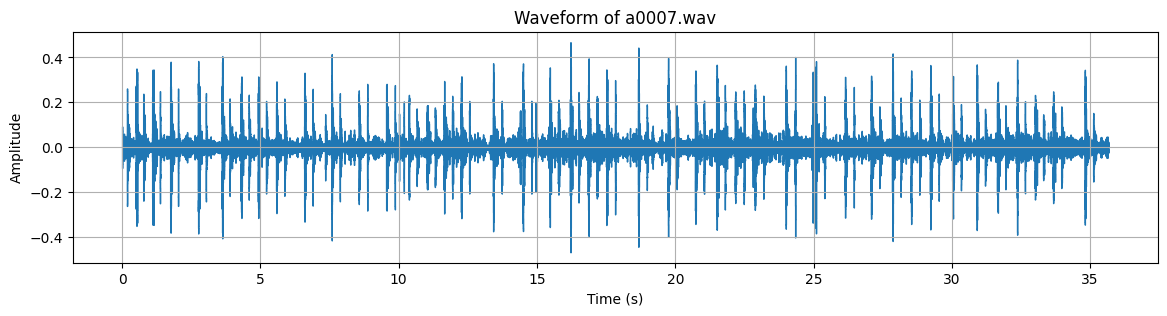

In [ ]:
# plot waveform
plt.figure(figsize=(14, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of a0007.wav")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

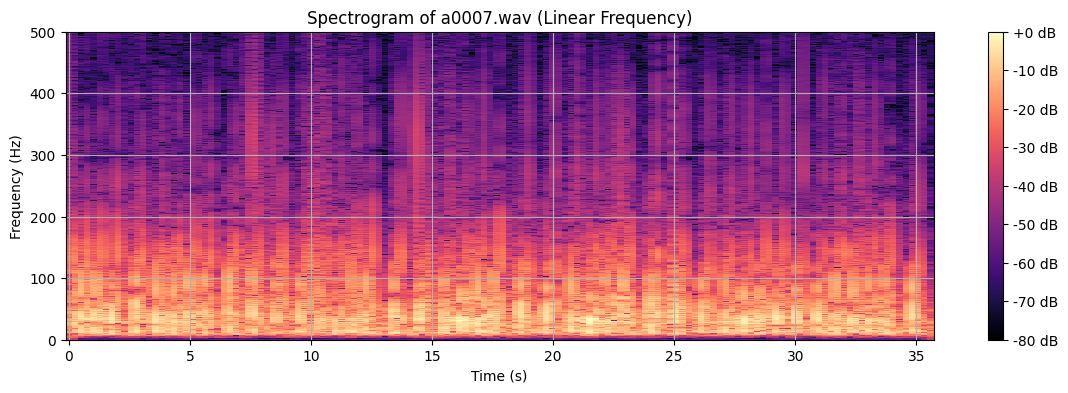

In [ ]:
# frequency band
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(14, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram of a0007.wav (Linear Frequency)")
plt.ylim(0, 500)  # Only show low frequencies up to 500Hz
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.grid()
plt.show()

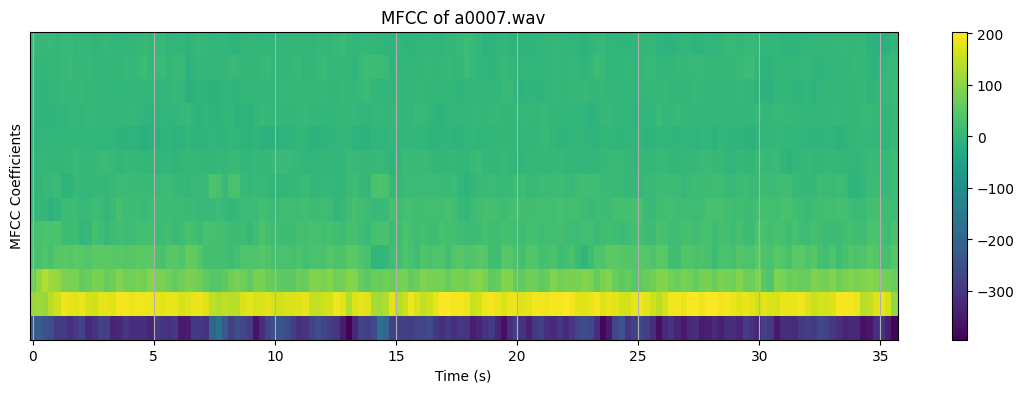

In [15]:
# using mfcc
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(14, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar()
plt.title("MFCC of a0007.wav")
plt.xlabel("Time (s)")
plt.ylabel("MFCC Coefficients")
plt.grid()
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [17]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2592, 40000) (648, 40000) (2592,) (648,)


In [18]:
X_train[0]

array([-4.3080286e+02, -4.3874075e+02, -4.3806848e+02, ...,
       -8.6528236e-01, -2.9908699e-01,  7.2789741e-01],
      shape=(40000,), dtype=float32)

In [19]:
X_test[0]

array([-423.3806 , -420.55322, -422.3335 , ...,    0.     ,    0.     ,
          0.     ], shape=(40000,), dtype=float32)

In [21]:
y_train

array([0, 0, 1, ..., 1, 0, 0], shape=(2592,))

In [22]:
y_test

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [58]:
#model build
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)  # shape (n_samples, 2)
y_test_cat = to_categorical(y_test)

# ANN
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_encoded)), activation='softmax') # classification
])

d:\ACC-HPC\files\AI\project\heartbeat\myenv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
# model compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │    10,240,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,273,410 (39.19 MB)

 Trainable params: 10,273,410 (39.19 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
history = model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    class_weight={0:1.0,1:2.0},
    verbose=1
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7530 - loss: 8.2910 - val_accuracy: 0.8131 - val_loss: 4.7881
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8037 - loss: 6.1092 - val_accuracy: 0.8516 - val_loss: 1.2871
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8418 - loss: 2.9799 - val_accuracy: 0.8709 - val_loss: 1.0558
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.8558 - loss: 1.8198 - val_accuracy: 0.8902 - val_loss: 0.9960
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.8731 - loss: 1.5533 - val_accuracy: 0.8362 - val_loss: 1.1498
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8842 - loss: 1.0012 - val_accuracy: 0.8805 - val_loss: 0.7490
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8997 - loss: 0.6923 - val_accuracy: 0.8902 - val_loss: 0.7517
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.8857 - loss: 0.7090 - val_accuracy: 0.8882 -

In [63]:
test_loss, test_acc = model.evaluate(X_test,y_test_cat)
print("Validation Accuracy:", test_acc)
print("Validation Loss:", test_loss)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9167 - loss: 0.6011
Validation Accuracy: 0.9166666865348816
Validation Loss: 0.6010755896568298


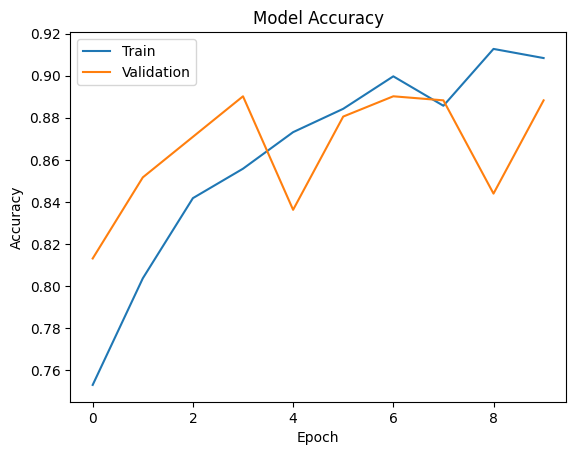

In [64]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

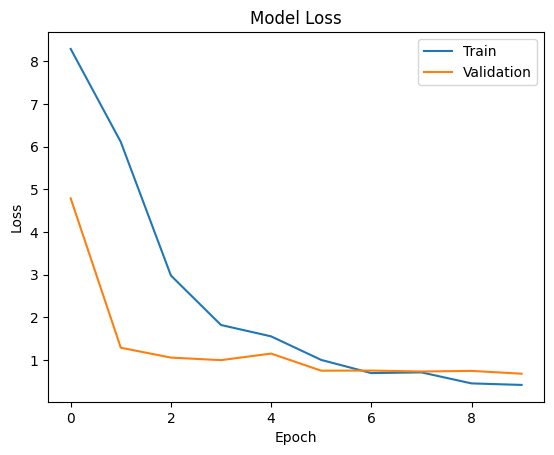

In [65]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [66]:
# Get predicted probabilities
y_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = y_prob.argmax(axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [68]:
# Sklearn metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9166666666666666
Confusion Matrix:
 [[498  17]
 [ 37  96]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       515
           1       0.85      0.72      0.78       133

    accuracy                           0.92       648
   macro avg       0.89      0.84      0.86       648
weighted avg       0.91      0.92      0.91       648



In [71]:
test_audio_path = "training-a/a0008.wav"   # change this to your test file

# Extract features
test_features = extract_features(test_audio_path)

if test_features is not None:
    # Convert to array and reshape
    test_features = np.array(test_features).reshape(1, -1)

    # Apply the same scaler used during training
    test_features = scaler.transform(test_features)

    # Predict
    prediction_prob = model.predict(test_features)
    predicted_class = prediction_prob.argmax(axis=1)[0]

    # Convert back to original label
    predicted_label = encoder.inverse_transform([predicted_class])[0]

    print("Predicted Class:", predicted_label)
    print("Probability:", prediction_prob)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: 1
Probability: [[1.2130658e-09 1.0000000e+00]]


In [72]:
model.save("my_model.keras")


In [ ]:
model.save('model.h5')
